## Natural gradient

#### Краткий синопсис

В этой части мы рассмотрим тему, которая находится на границе тем о матрице Фишера и KL-дивергенции. Будем использовать оптимизировать по метрике KL (натуральные градиенты) и считать метрики Васерштейна.

### Maximum likelihood оптимизация

Очень часто в машинном обучении и статистике возникает задача когда есть данные $X$, некоторое параметрическое распределение $p(x | \theta)$ и желание найти параметры $\theta$. 

Самые лучшие параметры это те которые минимизируют функцию правдоподобия: $\mathcal{L}(X, \theta)$, во многих случаях это можно сделать аналитически(почти для всех известных нам именных распределений).

В случае если нет возможности посчитать аналитически MLE-оценки приходится обращаться к итеративным методам оптимизации. Один из самых популярных способов это градиентный спуск, который, формально решает следующую задачу:

$$d \theta = \arg \max \mathcal{L}(X|\theta + d \theta), s.t. ||d\theta|| < \epsilon$$

И результатом решения этой задачи является:

$$d\theta = \frac{\nabla_\theta \mathcal{L}}{||\nabla_\theta \mathcal{L}||} \epsilon$$

Оптимально ли это? 

Мы ограничиваем наш шаг $||d\theta||$ сферой радиусом $\epsilon$ в евклидовом пространстве, но это не особо разумно неразумно. 

К примеру, сравним два распределения с $\mu_1 = -2, \mu_2 = 2$, а дисперсия фиксирована и равна $\sigma_1 = \sigma_2 = 1$.

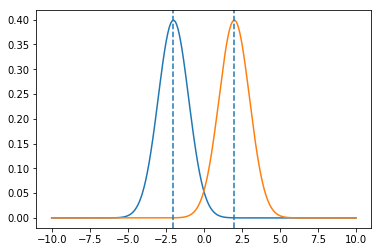

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy
from scipy.stats import norm
% matplotlib inline
x = np.linspace(-10, 10, 1000)

plt.plot(x, norm.pdf(x, -2, 1))
plt.plot(x, norm.pdf(x, 2, 1))
plt.axvline(-2, linestyle='--')
plt.axvline(2, linestyle='--')

plt.show()

И сравним два распределения с $\mu_1 = -2, \mu_2 = 2$, c $\sigma_1 = \sigma_2 = 5$.

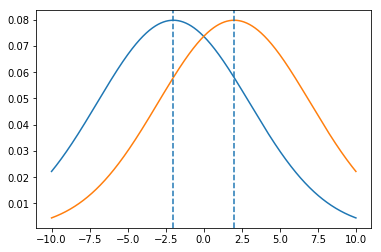

In [3]:
x = np.linspace(-10, 10, 1000)

plt.plot(x, norm.pdf(x, -2, 5))
plt.plot(x, norm.pdf(x, 2, 5))
plt.axvline(-2, linestyle='--')
plt.axvline(2, linestyle='--')

plt.show()

Чисто по евклидовой метрики растояние между ними одинаково, но на второй картинке распределения более похожие друг на друга чем на первой.

Это можно увидеть если вместо евклидовой метрики смотреть на растояние Кульбака-Лейблера между ними:

In [4]:
entropy(norm.pdf(x, -2, 5), norm.pdf(x, 2, 5)), entropy(norm.pdf(x, -2, 1), norm.pdf(x, 2, 1))

(0.24465034406492298, 7.9999999999999805)

По этой причине мы бы хотели научиться решать следующую задачу:

$$d \theta = \arg \max \mathcal{L}(X|\theta + d \theta), s.t. KL\left( p(x| \theta) || p(x| \theta + d \theta) \right) < \epsilon$$

То есть мы хотели бы на каждом шаге оптимизации делать шаг на $\epsilon$ по метрике KL, а не по метрике $L_2$.


В этом семинаре мы покажем как это делать.

Наши шаги:

  1. Мы вспомним как выглядит 2D-гауссиана и посчитаем для неё log-likelihood и градиент по log-likelihood.
  2. Нам это понадобится чтобы реализовать градиентный спуск.
  3. Далее мы вспомним, что такое KL-дивергенция и разложим ёё по Тейлору чтобы найти шаг оптимизации для минимизации KL-дивергенции. 
  4. Вспомним про связь гессиана KL-дивергенции и матрицы Фишера.
  5. Реализуем вот это вот всё.

### Генерация данных

Сгенерируем данные из распределения 2D-гауссианы с 5 параметрами: $\vec{\mu} = [2, -6]$, $\Sigma = \begin{pmatrix}
5 & 0.8\\
0.8 & 2
\end{pmatrix}$.

In [5]:
true_parameters = {
    'mean': np.array([2, -6]),
    'cov': np.array([[5, 0.8], 
                     [0.8, 2]])
}

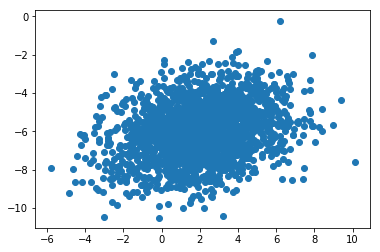

In [6]:
X_decart = np.random.multivariate_normal(**true_parameters, size=(2000,))
plt.scatter(X_decart[:, 0], X_decart[:, 1])

### Ввод функция для расчёта log-likelihood и pdf.

Первым делом, вспомним как выглядят плотность и log-likelihood для 2D-гаусса.


$$p(x|\mu, \Sigma) = \frac{1}{2 \pi |\Sigma|^{1/2}} \exp\left( - \frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right)$$

In [8]:
def norm_2d_pdf(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    """
    pdf нормального распределения в точке x
    """
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    
    ll= 1/(2*np.pi*np.linalg.det(cov)**(1/2))
    ll*= np.exp( -0.5*(x-mean).dot(np.linalg.inv(cov).dot(x-mean)))
    return ll

assert np.abs(norm_2d_pdf(np.array([2., -6.]), **true_parameters) - 0.052021420545533555) < 1e-8
assert np.abs(norm_2d_pdf(np.array([1., -4.]), **true_parameters) - 0.013538015908347703) < 1e-8

$$ \log p(x | \mu, \Sigma) = - \frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) - \log(2 \pi) - \frac{1}{2} \log |\Sigma| $$

In [13]:
def norm_2d_ll(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    """
    log-pdf нормального распределения в точке x
    """
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    #ll= 1/(2*np.pi*np.linalg.det(cov)**(1/2))
    #ll*= np.exp( -0.5*(x-mean).dot(np.linalg.inv(cov).dot(x-mean)))
    #ll= np.log(ll)
    ll=-0.5*(x-mean).dot(np.linalg.inv(cov).dot(x-mean))
    ll-=np.log(2*np.pi)+ 1/2*np.log(np.linalg.det(cov))
    
    return ll

assert np.abs(norm_2d_ll(np.array([-40., 33.3]), **true_parameters) + 745.0185997116541) < 1e-8

In [14]:
def norm_2d_ll_array(X, mean, cov):
    ll = 0
    for x in X:
        ll += norm_2d_ll(x, mean, cov)
    return ll

### Градиент 2D-нормального распределения

Мы хотим посчитать $\frac{\partial \log p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}} $, где p это наша плотность вероятности, а $\theta$ - параметры распределения(среднее и матрица ковариации).

Подсказки:

$$\frac{\partial \log |X|}{\partial X} = (X^{-1})^T = X^{-T}$$

$$\frac{\partial \log a^T X^{-1} b}{\partial X} = -X^{-T} a b^T X^{-1}$$


Книга по всевозможным матричным вычислениям for your interest: 
http://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf

In [17]:
np.outer?

In [22]:
def norm_2d_grad(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    """
    Градиент от log-pdf по mu и cov
    """
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    #cov_inv=np.linalg.inv(cov)
    #grad_mean= cov_inv.dot(x-mean)
    #grad_cov=-(cov_inv - cov_inv.dot(np.outer(x-mean, x-mean).dot(cov_inv)/2))
    cov_inv = np.linalg.inv(cov)
    grad_mean = cov_inv.dot(x - mean)
    grad_cov = -(cov_inv - cov_inv.dot(np.outer(x - mean, x - mean)).dot(cov_inv)) / 2
    
    return grad_mean, grad_cov

grad_mean, grad_cov = norm_2d_grad(np.array([2., -6.]), **true_parameters)
assert np.allclose(grad_mean, np.array([0., 0.])) and np.allclose(grad_cov, np.array([[-0.10683761,  0.04273504],
                                                                                      [ 0.04273504, -0.26709402]]))

grad_mean, grad_cov = norm_2d_grad(np.array([1., -4.]), **true_parameters)
assert np.allclose(grad_mean, np.array([-0.38461538,  1.15384615])) and np.allclose(grad_cov, np.array([[-0.03287311, -0.17915845],                                                                                                    [-0.17915845,  0.39858646]]))

### KL дивергенция

KL-дивергенция выглядит следующим образом:

$$KL\left(p(x|\theta)||p(x|\theta')\right) = \int p(x|\theta) \log \frac{p(x|\theta)}{p(x|\theta')} dx $$

А теперь зададимся вопросом: как нам оптимизировать параметры так чтобы спускаться с постоянной скоростью по метрике KL?

Для этого расмотрим $\mathrm{KL}\left[ p_{\theta} || p_{\theta + d \theta} \right]$ - KL-дивергенцию от двух очень близких друг к другу распределений и разложим эту функцию по Тейлору при $d \theta \rightarrow 0$:

$$
\mathrm{KL}\left[ p_{\theta} || p_{\theta + d \theta} \right] \approx \dots
$$



KL-дивергенция между двумя 2D-нормальными распределениями:


$$KL\left( p(x, \mu_1, \Sigma_1) || p(x, \mu_2, \Sigma_2) \right) = \frac{1}{2} \left[ \log \frac{|\Sigma_2|}{|\Sigma_1|} +
\mathrm{Tr} [\Sigma_2^{-1} \Sigma_1] + (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1) - 2 \right]$$

In [29]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}

def mse_difference(parameters_1, parameters_2):
    res = (((parameters_1['mean'] - parameters_2['mean'])**2).sum() + 
          ((parameters_1['cov'] - parameters_2['cov'])**2).sum())
    return res / (2 + 4)

def kl_difference(parameters_1, parameters_2):
    kl = 0
    #kl += np.log(np.linalg.det(parameters_2['cov']/parameters_1['cov']))
    #kl += np.trace (np.linalg.inv(parameters_2['cov'].dot(parameters_1['cov'])))
    kl += np.log( np.linalg.det(parameters_2['cov']) / np.linalg.det(parameters_1['cov']) )
    kl += np.trace( np.linalg.inv(parameters_2['cov']).dot(parameters_1['cov']) )
    #kl += (parameters_2['mean'] -parameters1['mean'].dot(parameters_2['mean']- parameters_1['mean']))
    kl += (parameters_2['mean'] - parameters_1['mean']).dot(
        np.linalg.inv(parameters_2['cov']).dot(parameters_2['mean'] - parameters_1['mean'])
    )
    kl -=2
    kl/=2
    return kl

assert np.abs(kl_difference(parameters, true_parameters) - 11.560530337552443) < 1e-6
assert np.abs(kl_difference(true_parameters, parameters) - 21.38177735475525) < 1e-6

### Связь KL-дивергенции и матрицы Фишера

Гессиан log-likelihood функции это одна из форм записи матрицы Фишера:

$$I_n = E \left[ \mathrm{H}_{\log p(x | \theta)} \right]$$

Таким образом, матрица Фишера, гессиан log-likelihood функции и гессиан KL-дивергенции это одно и тоже.

### Расчёт матрицы Фишера

Более удобный способ расчёта матрицы Фишера:

$$I_n = E\left[ \left( \frac{\partial \log p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}} \right) 
\left( \frac{\partial \log p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}}\right)^T  \right]$$


Производную мы посчитали выше. А как нам посчитать матожидание?

Усреднение по элементам выборки есть приближение среднего,поэтому самый простой способ это посчитать матрицу Фишера для каждого элемента нашей выборки и усреднить.

In [32]:
np.concatenate?

In [31]:
np.ravel?

In [30]:
np.vstack?

In [34]:
from typing import Callable, Union
def empirical_fisher(grad_func: Callable, X: np.ndarray, parameters: dict) -> Union[np.ndarray, np.ndarray]:
    """
    Функция принимает на вход матрицу X размера N x 2, функцию расчёта градиента
    для среднего и ковариации и параметры нормального распределения.
    
    На выход возвращается усреднённый по выборке градиент и матрица Фишнера.
    """
    N = len(X)
    grads = []
    for x in X:
        # Посчитать градиент для сэмпла
        grad_mean,grad_cov=grad_func(x,**parameters)
        # "Вытянуть" градиент в один вектор не забыв про условие симметричности матрицы ковариации
        grad=np.concatenate([grad_mean, grad_cov.ravel()[[0,1,3]]])
        grad[3] *= 2 #?
        grads.append(grad)
    grads = np.vstack(grads)
    fisher = np.cov(grads.T)
    return grads.mean(axis=0), fisher




grad, fisher = empirical_fisher(grad_func=norm_2d_grad, X=np.array([[1., 0.], [0., 1.], [1.7, -2.7]]), parameters=true_parameters)


assert np.allclose(grad, np.array([-0.6994302 ,  2.99643875,  0.17642207, -2.25459919,  4.61902881]))
assert np.allclose(fisher, np.array([[ 0.11597511, -0.36640429, -0.07877717,  0.57713526, -1.03771913],
                                     [-0.36640429,  1.19040075,  0.24294858, -1.81013248,  3.3234273 ],
                                     [-0.07877717,  0.24294858,  0.05458379, -0.39441812,  0.69675323],
                                     [ 0.57713526, -1.81013248, -0.39441812,  2.87737592, -5.14595728],
                                     [-1.03771913,  3.3234273 ,  0.69675323, -5.14595728,  9.34679459]]))

def vec_to_covariance(vec):
    m = np.zeros((2, 2))
    m.ravel()[[0, 1, 3]] = vec
    m[1, 0] = m[0, 1]
    return m

In [35]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}
lr = 1e-2
sgd_mse = []
sgd_mse.append(mse_difference(true_parameters, parameters))

sgd_kl = []
sgd_kl.append(kl_difference(true_parameters, parameters))

sgd_mle = []
sgd_mle.append(norm_2d_ll_array(X_decart, **parameters))

for i in tqdm(range(100)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    for x in X_decart:
        grad_mean, grad_cov = norm_2d_grad(x, **parameters)
        grad_mean_total += grad_mean / len(X_decart)
        grad_cov_total += grad_cov / len(X_decart)
        
    parameters['mean'] += lr * grad_mean_total
    parameters['cov'] += lr * grad_cov_total
    
    sgd_mse.append(mse_difference(true_parameters, parameters))
    sgd_kl.append(kl_difference(true_parameters, parameters))
    sgd_mle.append(norm_2d_ll_array(X_decart, **parameters))

    
print('mean', parameters['mean'], true_parameters['mean'])
print('cov', parameters['cov'], true_parameters['cov'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


mean [ 0.63001949 -1.93899005] [ 2 -6]
cov [[ 2.05039376 -0.47080516]
 [-0.47080516  3.26732016]] [[5.  0.8]
 [0.8 2. ]]


In [36]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}

lr = 1e-2
nat_grad_mse = []
nat_grad_mse.append(mse_difference(true_parameters, parameters))

nat_grad_kl = []
nat_grad_kl.append(kl_difference(true_parameters, parameters))

nat_grad_mle = []
nat_grad_mle.append(norm_2d_ll_array(X_decart, **parameters))

for i in tqdm(range(100)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    grad, fisher = empirical_fisher(norm_2d_grad, X=X_decart, parameters=parameters)
    natural_grad = np.linalg.inv(fisher).dot(grad)
    # natural_grad = natural_grad / np.linalg.norm(natural_grad)
    
    parameters['mean'] += lr * natural_grad[:2]
    parameters['cov'] += lr * vec_to_covariance(natural_grad[2:])
    
    nat_grad_mse.append(mse_difference(true_parameters, parameters))
    nat_grad_kl.append(kl_difference(parameters, true_parameters))
    nat_grad_mle.append(norm_2d_ll_array(X_decart, **parameters))

    
print('mean', parameters['mean'], true_parameters['mean'])
print('cov', parameters['cov'], true_parameters['cov'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


mean [ 1.34113986 -4.37826164] [ 2 -6]
cov [[1.10539076 0.23084164]
 [0.23084164 0.424913  ]] [[5.  0.8]
 [0.8 2. ]]


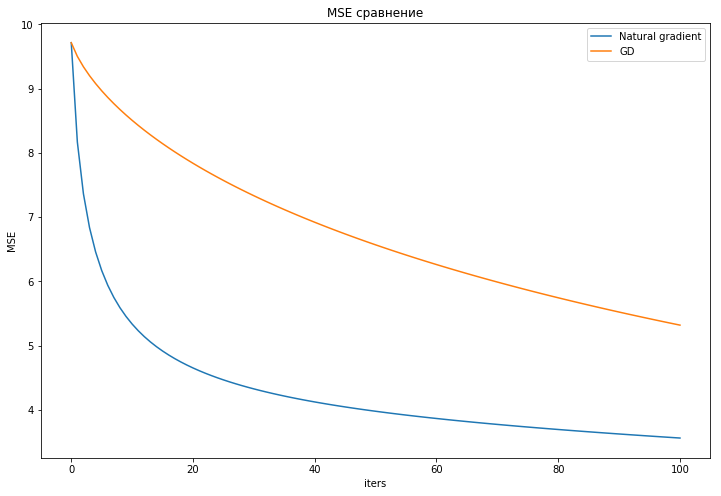

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_mse, label='Natural gradient')
plt.plot(sgd_mse, label='GD')
plt.title('MSE сравнение')
plt.xlabel('iters')
plt.ylabel('MSE')
plt.legend()
plt.show()

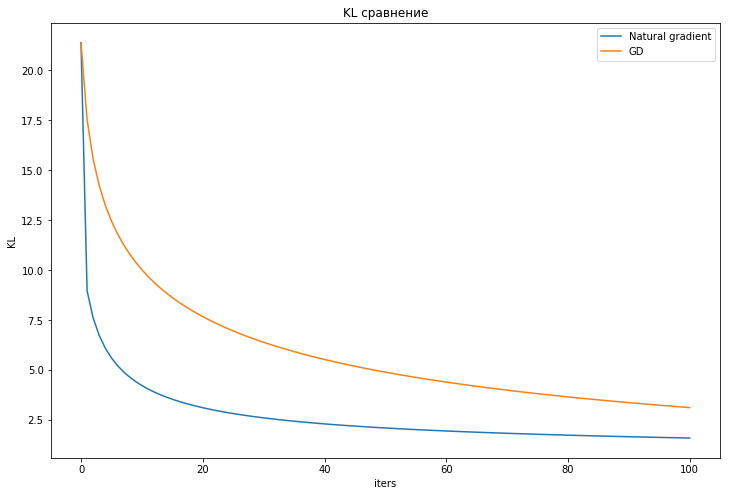

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_kl, label='Natural gradient')
plt.plot(sgd_kl, label='GD')
plt.title('KL сравнение')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

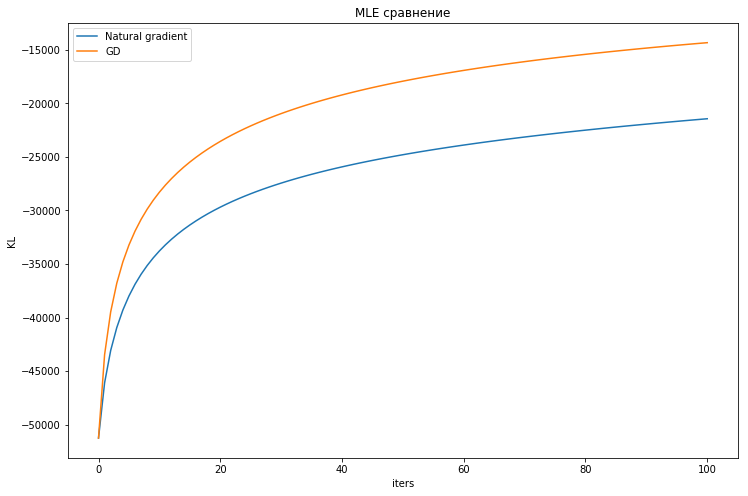

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_mle, label='Natural gradient')
plt.plot(sgd_mle, label='GD')
plt.title('MLE сравнение')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

### Дополнительное задание

Выше мы считали матрицу Фишера эмпирическим путём. Это нормальный способ если выборка большая или если интегрировать по плотности распределения сложно, к примеру, если плотность распределения задаётся нейронной сетью.

Для нормального распределения матрицу Фишера не сложно посчитать аналитическим путём. 

Напишите свой код для аналитического расчёта матрицы Фишера в функции ниже(ничего кроме параметров распределения вам не понадобится).

Запустите код и скажите что изменилось?

In [ ]:
def analytical_fisher(parameters: dict) -> Union[np.ndarray, np.ndarray]:
    """
    Функция принимает на вход матрицу X размера N x 2, функцию расчёта градиента
    для среднего и ковариации и параметры нормального распределения.
    
    На выход возвращается усреднённый по выборке градиент и матрица Фишнера.
    """
    N = len(X)
    grads = []
    for x in X:
        grad_mean, grad_cov = grad_func(x, **parameters)
        grad = np.concatenate([grad_mean, grad_cov.ravel()[[0, 1, 3]]])
        grads.append(grad)
    
    
    fisher = <YOUR CODE>
    raise ValueError('Where is Fisher, dude?')
    
    return np.vstack(grads).mean(axis=0), fisher

In [ ]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}
lr = 1e-2
nat_grad_mse = []
nat_grad_mse.append(mse_difference(true_parameters, parameters))

nat_grad_kl = []
nat_grad_kl.append(kl_difference(true_parameters, parameters))

for i in tqdm(range(200)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    grad, fisher = analytical_fisher(norm_2d_grad, X=X_decart, parameters=parameters)
    natural_grad = np.linalg.inv(fisher).dot(grad)
    
    parameters['mean'] += lr * natural_grad[:2]
    parameters['cov'] += lr * vec_to_covariance(natural_grad[2:])
    
    nat_grad_mse.append(mse_difference(true_parameters, parameters))
    nat_grad_kl.append(kl_difference(parameters, true_parameters))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_kl, label='Natural gradient')
plt.plot(sgd_kl, label='SGD')
plt.title('Comparison')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

## Wasserstein distance

Общая формула для расстояния Васерштейна:

$$W_p(p, q) = \inf\limits_{\pi \in \Gamma(u, v)} \int\limits_{\mathbb{M} \times \mathbb{M}} d(x, y)^p d \pi(x, y)$$


Но мы будем расматривать самый простой случай: 1D-растояние с $p=1$.

В таком случае формула упрощается до:

$$W_1(p, q) = \inf\limits_{\pi \in \Gamma(u, v)}  \int\limits_{\mathbb{R} \times \mathbb{R}} |x - y| \pi(x, y)$$

Физический смысл: как сделать наименьшее количество работы чтобы перенести лопатой землю из одной кучки в другую:

![](https://sbl.inria.fr/fig/Earth_mover_distance_logo.png)

In [40]:
from scipy.stats import wasserstein_distance
from itertools import permutations
import numpy as np

In [41]:
def wasserstein_distance_brute_force(x, y):
    assert len(x) == len(y)
    min_distance = np.inf
    argmin_permutation = None
    for permutation in permutations(np.arange(len(x))):
        distance= np.mean(np.abs(x[np.array(permutation)]-y))
        if min_distance >distance:
            min_distance=distance
            argmin_permutation= permutation
    return min_distance


x = np.random.randn(4)
y = np.random.randn(4)
assert np.abs(wasserstein_distance_brute_force(x, y) - wasserstein_distance(x, y)) < 1e-8

In [42]:
def wasserstein_distance_smart_force(x, y):
    x_idx = np.argsort(x)
    y_idx = np.argsort(y)
    
    distance = np.mean(np.abs(x[x_idx]-y[y_idx]))
    return distance

wasserstein_distance_brute_force(x, y) == wasserstein_distance_smart_force(x, y)

False

In [43]:
import time
times_brute = []
times_smart = []
Ns = np.arange(2, 10)
for i in Ns:
    x = np.random.randn(i)
    y = np.random.randn(i)
    t0 = time.time()
    wasserstein_distance_brute_force(x, y)
    t1 = time.time()
    times_brute.append(t1 - t0)
    t0 = time.time()
    wasserstein_distance_smart_force(x, y)
    t1 = time.time()
    times_smart.append(t1 - t0)

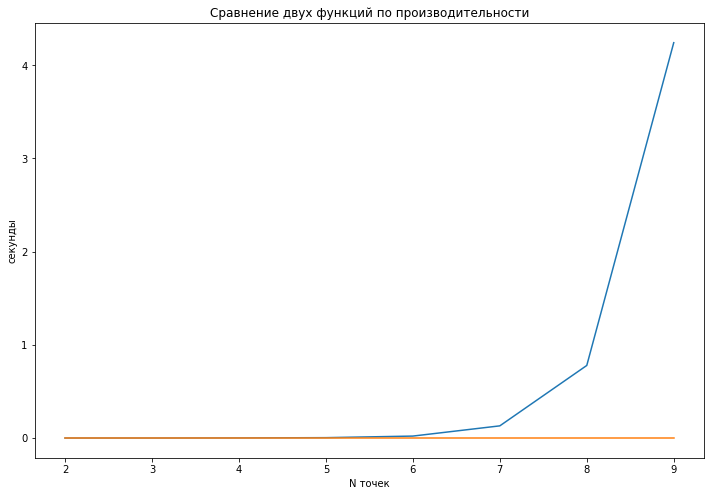

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(Ns, times_brute, label='brute force')
plt.plot(Ns, times_smart, label='smart force')
plt.title('Сравнение двух функций по производительности')
plt.xlabel('N точек')
plt.ylabel('секунды')
#plt.yscale('log')
plt.show()

In [46]:
N = 100

x = np.random.randn(N) - 3
y = np.random.randn(N) + 3

In [47]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead
from bokeh.models import CustomJS, Slider
from bokeh.layouts import row
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance
def KL(P, Q):
    epsilon = 0.00001

    Pp = P+epsilon
    Pp /= Pp.sum()
    Qq = Q+epsilon
    Qq /= Qq.sum()

    divergence = np.sum(Pp*np.log(Pp/Qq))
    return divergence

output_notebook()

bw = 0.1

x_linspace = np.linspace(-10, 10, 1000)
x_idx = np.argsort(x)
y_idx = np.argsort(y)
i = 0
density_x = gaussian_kde(x, bw_method=bw)
density_y = gaussian_kde(y, bw_method=bw)
fig = figure()
fig.title.text = "Wasserstain distance={}, KL={}".format( wasserstein_distance_smart_force(x, y), KL(density_x(x_linspace),
                                                                                                     density_y(x_linspace)))
density_x_bokeh = fig.line(x_linspace, density_x(x_linspace), color="red")
density_y_bokeh = fig.line(x_linspace, density_y(x_linspace), color="blue")
arrow = fig.line([x[x_idx[i]], y[x_idx[i]]], [density_x(x[x_idx[i]])[0], density_y(y[x_idx[i]])[0]], color='green')


def update_plot(n_moved):
    x_linspace = density_x_bokeh.data_source.data['x']
    global density_x
    global density_y
    x_copy = x.copy()
    for i in range(n_moved):
        x_copy[x_idx[i]] = y[y_idx[i]]
    density_x = gaussian_kde(x_copy, bw_method=bw)
    density_x_bokeh.data_source.data['y'] = density_x(x_linspace)
    fig.title.text = "Wasserstain distance={}, KL={}".format(wasserstein_distance_smart_force(x_copy, y), KL(density_x(x_linspace),
                                                                                                             density_y(x_linspace)))
    arrow.data_source.data['x'] = [x[x_idx[i + 1]], y[y_idx[i + 1]]]
    arrow.data_source.data['y'] = [density_x(x[x_idx[i + 1]])[0], density_y(y[y_idx[i + 1]])[0]]

    push_notebook(handle=bokeh_handle)  

Loading BokehJS ...

In [48]:
callback = CustomJS(code="""
if (IPython.notebook.kernel !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "update_plot(" + cb_obj.value + ")";
    kernel.execute(cmd, {}, {});
}
""")

slider = Slider(start=0, 
                end=len(x),
                value=0,
                step=1,
                title="Moved dots",
                callback=callback)
bokeh_handle = show(row(fig, slider), notebook_handle=True)